
<br>
Observation des réseaux de relations entre les différentes occupations des écrivain-es. Continuation nocturne du carnet "reseaux_occupations".<br>


In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import re

L'adresse de DBPedia, où la requête doit être adressée.

In [2]:
sparql = SPARQLWrapper("http://dbpedia.org/sparql")

Le format du résultat de la requête. L'objet, en python, sera un dictionnaire.

In [3]:
sparql.setReturnFormat(JSON)

La requête, qui trouve les Writers et leurs occupations.

In [4]:
sparql.setQuery(
    "PREFIX dbo: <http://dbpedia.org/ontology/>\n"
    "PREFIX dbr: <http://dbpedia.org/resource/>\n"
    "\n"
    "SELECT DISTINCT ?person ?occupation\n"
    "WHERE {\n"
    "    ?person ?a dbr:Writer ;\n"
    "            dbo:occupation ?occupation .\n"
    "}\n"
)

Envoyer la requête.

In [5]:
results = sparql.queryAndConvert()

Aperçu de la structure de l'objet retourné. Le premier niveau du dictionnaire.

In [6]:
results.keys()

dict_keys(['head', 'results'])

L'entrée "head" (en-tête), qui décrit la structure des données.

In [7]:
results["head"]

{'link': [], 'vars': ['person', 'occupation']}

L'entrée "results".

In [8]:
for i, j in results["results"].items():
    if type(j) == list:
        print(f'results["results"]["{i}"]:', type(j), j[:2])
    elif type(j) == dict:
        print(
            f'results["results"]["{i}"]:', type(j), list(j.keys())[:3]
        )
    else:
        print(f'results["results"]["{i}"]:', type(j), j)

results["results"]["distinct"]: <class 'bool'> False
results["results"]["ordered"]: <class 'bool'> True
results["results"]["bindings"]: <class 'list'> [{'person': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Caiseal_Mór'}, 'occupation': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Musician'}}, {'person': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Caiseal_Mór'}, 'occupation': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Artist'}}]


Seul ce qui se trouve dans ['results']['bindings'] m'intéresse. Je commence par construire un simple liste de tuples selon le schéma (person, occupation).

In [9]:
pairs = [
    (i["person"]["value"], i["occupation"]["value"])
    for i in results["results"]["bindings"]
]
pairs[:3]

[('http://dbpedia.org/resource/Caiseal_Mór',
  'http://dbpedia.org/resource/Musician'),
 ('http://dbpedia.org/resource/Caiseal_Mór',
  'http://dbpedia.org/resource/Artist'),
 ('http://dbpedia.org/resource/Caiseal_Mór',
  'http://dbpedia.org/resource/Writer')]

Pour augmenter le nombre de données (la raison apparaitra plus bas, mais repose sur la limitation à 10000 résultats par requête auprès de dbpedia), je fais également des requêtes avec d'autres occupations que Writers.

In [10]:
queries = {}
separated_results = {}
pairs_supp = {}
groups = ["Novelist", "Poet", "Playwright"]
for i in groups:
    queries[i] = SPARQLWrapper("http://dbpedia.org/sparql")
    queries[i].setReturnFormat(JSON)
    queries[i].setQuery(
        "PREFIX dbo: <http://dbpedia.org/ontology/>\n"
        "PREFIX dbr: <http://dbpedia.org/resource/>\n"
        "\n"
        "SELECT DISTINCT ?person ?occupation\n"
        "WHERE {\n"
        f"    ?person ?a dbr:{i} ;\n"
        "            dbo:occupation ?occupation .\n"
        "}\n"
    )
    separated_results[i] = sparql.queryAndConvert()
    pairs_supp[i] = [
        (i["person"]["value"], i["occupation"]["value"])
        for i in separated_results[i]["results"]["bindings"]
    ]
    pairs.extend(pairs_supp[i])

J'enlève le début des URI, pour ne garder que les noms et les occupations.

In [11]:
clean_pairs = [
    (
        i.replace("http://dbpedia.org/resource/", ""),
        # Je passe les occupations en lowercase pour faciliter
        # les recherches de caractères.
        j.replace("http://dbpedia.org/resource/", "").lower(),
    )
    for i, j in pairs
]
clean_pairs[:3]

[('Caiseal_Mór', 'musician'),
 ('Caiseal_Mór', 'artist'),
 ('Caiseal_Mór', 'writer')]

Certaines paires me sont inutiles, celles qui ont comme occupation "[nom de la personne]_PersonFunction".

In [12]:
[i for i in clean_pairs if "personfunction" in i[1]][:5]

[('Caitlin_Flanagan', 'caitlin_flanagan__personfunction__1'),
 ('Caleb_Garling', 'caleb_garling__personfunction__1'),
 ('Calla_Curman', 'calla_curman__personfunction__1'),
 ('Camille_Lemonnier', 'camille_lemonnier__personfunction__1'),
 ('Carl_Binder', 'carl_binder__personfunction__1')]

Je construis donc une nouvelle liste sans ces paires.

In [13]:
non_trivial_pairs = [
    i for i in clean_pairs if "personfunction" not in i[1]
]
len(non_trivial_pairs)

25692

Il y a des répétitions de paires, puisque les Novelist, les Poets, etc., sont souvent aussi catégorisé-es comme Writer. En fait, l'ajout des nouveaux groupes n'a peut-être pas été si utile. [À faire, peut-être: ajouter des occupations liées à la littérature mais plutôt, par exemple, du côté des éditeurices, des bibliothécaires, des critiques. Ou, à l'inverse, des artistes, des musicien-nes, pour voir si les activités annexes sont du même type, s'il y a des recoupements, etc.]

In [14]:
uniqpairs = list(set(non_trivial_pairs))
len(uniqpairs)

6423

Puisque ce sont les interactions entre occupations qui m'intéresse, je ne vais garder que les données qui concernent les personnes avec au moins deux entrées. Je commence par faire une liste des noms.

In [15]:
names = [i for i, j in uniqpairs]
names[:3]

['George_Weideman', 'Bernard_Seigal', 'Rick_Ducommun']

Le nombre total d'occurences de noms.

In [16]:
len(names)

6423

Le nombre d'occurences de noms qui apparaissent plusieurs fois.

In [17]:
names_repeated = [i for i in names if names.count(i) > 1]
len(names_repeated)

5021

Le nombre de noms qui apparaissent plusieurs fois. (Les données sont plus minces que ce que je pouvais espérer et il faudrait probablement opter pour une autre manière d'interroger DBPedia.)

In [18]:
len(set(names_repeated))

1782

Les premiers noms.

In [19]:
uniqnames = list(set(names_repeated))
uniqnames.sort()
for i in uniqnames[:5]:
    print(i)

A._C._Sreehari
A._Dorian_Otvos
A._N._Murthy_Rao
Aaron_Ehasz
Abd_Al_Munim_Al_Gilyani


Puisque chaque nom est unique, je peux utiliser les noms comme clés pour un dictionnaire. La valeur qui y sera attribuée sera une liste des occupations.

In [20]:
d = {}
for i in uniqnames:
    d[i] = []

Observer le dictionnaire avant d'y mettre les données.

In [21]:
for i in list(d.items())[:3]:
    print(i)

('A._C._Sreehari', [])
('A._Dorian_Otvos', [])
('A._N._Murthy_Rao', [])


Iterate sur les éléments de la variable clean_pairs qui contient les paires person/occupation, et append la liste des occupations de la personne

In [22]:
for name, occupation in uniqpairs:
    if name in uniqnames:
        d[name].append(occupation)

Observer une partie du dictionnaire.

In [23]:
for i in list(d.items())[:3]:
    print(i)

('A._C._Sreehari', ['writer', 'teacher', 'lyricist', 'poet'])
('A._Dorian_Otvos', ['composer', 'writer'])
('A._N._Murthy_Rao', ['professor', 'writer'])


L'occupation "Writer" est très présente C'est pour cela que j'ai fait des requêtes supplémentaires. Cela a permis d'ajouter un certain nombre d'entrées.

In [24]:
len([i for i, j in list(d.items()) if "Writer" not in j])

1782

Mais la question se pose, tout de même, de l'intérêt ici de l'occupation "Writer" (qui est aussi, dans DBPedia, une méta-occupation). Je préfère la retirer, étant donné que les poète-sses, les romancier-ères, les dramaturges, sont aussi des écrivain-es.

In [25]:
data_to_pop = [
    i for i in list(d.keys()) if len(d[i]) < 3 and "Writer" in d[i]
]
len(data_to_pop)

0

In [26]:
for i in data_to_pop:
    d.pop(i)

Le nombre d'entrées restantes dans le dictionnaires.

In [27]:
len(d)

1782

Il va désormais s'agir d'explorer les relations entre occupations en utilisant l'analyse de réseaux. Pour le début de l'exploration, je vais simplifier les données et regarder les relations d'occupations uniquement, en excluant les personnes des graphes, ou plus exactement: je vais créer un graphe avec un seul type de noeud, les occupations, et en réduisant les personnes à des nombres qui renforceront le poids des relations entre les noeuds-occupations. Plus une relation entre deux occupations (deux noeuds) sera répandue, et plus le lien entre elles sera considéré comme lourd.<br>
Pour créer un réseau reliant les occupations les unes aux autres, il faut d'abord créer des relations entre occupations, des nouvelles paires occupation/occupation.

In [28]:
occ_pairs = []
for name, occupations in d.items():
    for occ_one in occupations:
        for occ_two in occupations:
            if occ_two != occ_one:
                o = [occ_one, occ_two]
                o.sort()
                p = (o[0], o[1])
                occ_pairs.append(p)

Certaines paires ont plusieurs occurences: quand deux occupations cohabitent chez plusieurs personnes.

In [29]:
[i for i in occ_pairs if "biographer" in i and "novelist" in i][:10]

[('biographer', 'novelist'),
 ('biographer', 'novelist'),
 ('biographer', 'novelist'),
 ('biographer', 'novelist'),
 ('biographer', 'novelist'),
 ('biographer', 'novelist'),
 ('biographer', 'novelist'),
 ('biographer', 'novelist')]

Plutôt que d'avoir ainsi des doublons, on peut représenter le nombre d'occurences comme la force de la relation. Observer les relations avec le plus d'occurences.

In [30]:
count = Counter(occ_pairs)
count.most_common()[:10]

[(('poet', 'writer'), 342),
 (('journalist', 'writer'), 342),
 (('actor', 'writer'), 266),
 (('film_director', 'writer'), 264),
 (('film_director', 'film_producer'), 166),
 (('film_producer', 'writer'), 164),
 (('film_director', 'screenwriter'), 130),
 (('historian', 'writer'), 100),
 (('actor', 'film_director'), 88),
 (('screenwriter', 'writer'), 84)]

Pour produire une première visualisation, je fais une sous-liste des paires d'occupations les plus courantes.

In [31]:
relations_most_common = [
    (i[0], i[1], j)
    for i, j in list(count.most_common()[:30])
    if "writer" not in i
]
relations_most_common[:10]

[('film_director', 'film_producer', 166),
 ('film_director', 'screenwriter', 130),
 ('actor', 'film_director', 88),
 ('television_producer', 'television_writer', 76),
 ('film_producer', 'screenwriter', 70),
 ('screenwriter', 'television_producer', 66),
 ('journalist', 'poet', 66),
 ('playwright', 'poet', 62),
 ('novelist', 'poet', 62),
 ('actor', 'film_producer', 58)]

Construction d'un graphe avec ces paires d'occupations.

In [32]:
graph_most_common = nx.Graph()
for relation in relations_most_common:
    node1, node2 = relation[0], relation[1]
    graph_most_common.add_edge(node1, node2)

Tracer le graphe

In [33]:
def tracer_montrer_graphe_sans_poids(graph):

    # Positions des nœuds
    pos = nx.spring_layout(graph)
    nx.draw_networkx_edges(graph, pos, edge_color="gray")

    # Tracer les nœuds et les étiquettes
    nx.draw_networkx_nodes(
        graph, pos, node_color="lightblue", node_size=10
    )
    nx.draw_networkx_labels(graph, pos, font_size=12)

    # Afficher le graphe
    plt.axis("off")
    plt.show()

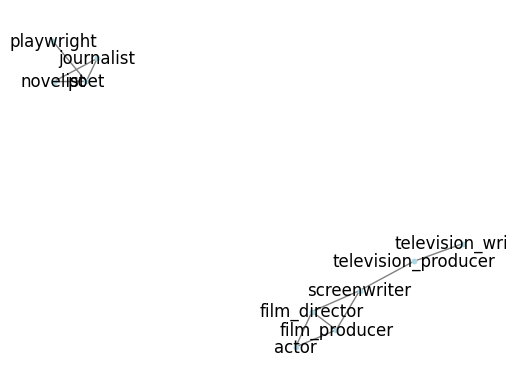

In [34]:
tracer_montrer_graphe_sans_poids(graph_most_common)

Cette première visualisation nous montre déjà des choses intéressantes, quoi que relativement triviales. Le graphe est séparé en deux clusters: les écritures littéraires et le journalisme d'un côté, les activités liées au cinéma ou à la télévision de l'autre. Ce premier découpage est intéressant du fait de l'annexion de l'occupation journalistique aux écritures littéraires. Le journalisme, du point de vue de ce graphe, peut bien apparaître, d'une part, comme un métier d'appoint typique des littérateurices; et d'autre part comme un espace d'expression publique dont les littérateurices se saisissent davantage que d'autres groupes d'écrivain-es. Surtout, ce découpage en deux clusters est moins un découpage entre deux types d'activités qu'entre deux "mondes de l'art" au sens de Howard Becker. Car, d'un point de vue technique, technologique, physiologique, etc., l'écriture pour la télévision est bien plus proche de l'écriture d'une pièce de théâtre que de l'acting. À moins qu'on entende par "écriture" un ensemble large de pratiques intégrant les formes de collaboration (réécrire sous la contrainte des équipes de tournages, discuter, reprendre des parties de scripts existants, etc.), auquel cas "l'écriture" du screenwriter a en effet beaucoup à voir avec l'acting, puisqu'il s'agit essentiellement d'une activité consistant à employer les mêmes critères et à cotoyer les mêmes personnes: celles et ceux du monde du cinéma.<br>
Par ailleurs, on peut voir, dans le cluster lié au cinéma, que les nodes 'actor' et 'television writer' sont très éloigné, tandis que les nodes 'actor' et 'screen writer' (l'écriture pour le cinéma) sont plus rapprochés: on peut ainsi faire l'hypothèse que le monde de la télévision n'est pas structuré avec la même souplesse que le monde du cinéma, et que l'assignation à des rôles professionnels définis y est plus forte. Toutefois, il faut fortement relativiser cette hypothèse: ces résultats sont probablement liés au biais induit par la sélection des paires d'occupations les plus courantes.

Fonction pour chercher les nodes connectés aux nodes contenant un mot ou une chaîne de caractère.

In [35]:
def connected_nodes(mot: str, graph=graph_most_common):
    a = [node for node in graph.nodes() if mot in node]
    b = []
    for i in a:
        b.extend(graph_most_common.neighbors(i))
    return (a, b)

Les nodes connectés à des nodes contenant le mot 'book'

In [36]:
connected_nodes("book")

([], [])